In [1]:
import sys
import os

# Get the absolute path of the scripts directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the scripts directory to Python's module search path
sys.path.append(root_dir)

# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline

# from feature-engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.outliers import OutlierTrimmer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel

# from scripts
from scripts.preprocessors import (
    IdealistaDataLoader,
    RareValueTrimmer,
    FrequentValueAmputer,
    UnaryFeatureDropper,
    RelativeFeatureGenerator,
    ProximityScoreGenerator
)

In [2]:
# to visualise al the columns in the dataframe
pd.pandas.set_option("display.max_columns", None)
# to display all the rows of the dataframe in the notebook
pd.pandas.set_option("display.max_rows", None)

# to display the plots in a nice way
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
data_loader = IdealistaDataLoader(
    read_path=f"../data/idealista",
    city="lisbon",
    operation="rent",
    date_or_unioned="unioned",
    include_geodata=True,
    include_openai=True,
    index_col="propertyCode",
)

data = data_loader.load_data()

In [4]:
# rowsandcolumnsofthedata
print(data.shape)

# visualisethedataset
data.head()

(3788, 107)


,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,rooms,bathrooms,address,province,municipality,district,country,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,neighborhood,newDevelopmentFinished,snapshotDate,formerPrice,priceChange,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,parkingSpacePrice,totalPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,hasSwimmingPool,hasBalcony,hasGarage,hasParking,hasAirConditioning,hasClotheslineSpace,hasBuiltInWardrobes,hasDishwasher,hasWashingMachine,hasDryer,hasElevator,isFurnished,isPetFriendly,isSmokingAllowed,isWheelchairAccessible,hasGarden,hasFireplace,hasAlarmSystem,hasCityViews,hasWaterViews,isLuxury,isTemporaryContract,isLongTermContract,isStudentFriendly,energyEfficiencyRating,hasHomeAppliances,hasOven,hasMicrowave,hasRefrigerator,hasStove,hasTerrace,hasStorageRoom,hasInternetIncluded,hasCableTVIncluded,hasSmartHomeFeatures,hasCCTV,hasGym,isNewlyRenovated,hasModernFinish,change,savedAd,notes
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33829652,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,KWPT-009130,33,1,2475.0,flat,rent,179.0,3,3,São Sebastião da Pedreira,Lisboa,Avenidas Novas,São Sebastião da Pedreira,pt,38.733429,-9.145003,False,https://www.idealista.pt/imovel/33829652/,439.0,Um apartamento nas Avenidas Novas? Conte-me ma...,False,good,False,True,13.826816,{'typology': 'flat'},"{'subtitle': 'Avenidas Novas, Lisboa', 'title'...",True,False,False,False,False,False,NaN,False,2025-01-13,2475.0,0.0,False,False,False,0.0,2475.0,3902.762342,83.378815,Dolce Vita Monumental,1626.342524,Entrecampos,1337.410328,Feira São João de Deus,466.306263,Jardim do Arco do Cego,1012.055636,Mercado Arco do Cego,250.261820,Saldanha,1142.440298,Miradouro do Parque Eduardo VII,641.621174,Parque Infantil do Jardim Gomes Amorim,64.135685,Saldanha,1890.872576,Rua Maria Andrade,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Unknown,True,True,False,False,True,False,False,False,False,False,False,False,False,True,NaN,NaN,NaN
33596155,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,KWPT-004534,33,bj,2150.0,flat,rent,170.0,3,3,rua das Picoas,Lisboa,Avenidas Novas,São Sebastião da Pedreira,pt,38.733908,-9.144531,False,https://www.idealista.pt/imovel/33596155/,373.0,Um apartamento para arrendar? Conte-me mais! E...,True,good,False,True,12.647059,{'typology': 'flat'},"{'subtitle': 'Avenidas Novas, Lisboa', 'title'...",True,False,False,False,False,False,NaN,False,2025-01-13,2150.0,0.0,False,False,False,0.0,2150.0,3954.901443,150.274403,Centro Comercial Atrium Saldanha,1576.198925,Entrecampos,1251.392666,Feira São João de Deus,380.225877,Jardim do Arco do Cego,929.438169,Mercado Arco do Cego,198.676223,Saldanha,1217.962245,Miradouro do Parque Eduardo VII,562.731979,Parque Infantil do Jardim Gomes Amorim,52.045424,Saldanha,1909.529635,Rua Maria Andrade,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Unknown,True,True,False,False,True,False,False,False,False,False,False,False,True,True,NaN,NaN,NaN
33896876,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,Match_01.216,21,8,1950.0,flat,rent,135.0,2,2,"rua Jorge Castilho, 8",Lisboa,Areeiro,Casal Vistoso,pt,38.740173,-9.128233,True,ht

In [5]:
data.columns.to_list()

['thumbnail',
 'externalReference',
 'numPhotos',
 'floor',
 'price',
 'propertyType',
 'operation',
 'size',
 'rooms',
 'bathrooms',
 'address',
 'province',
 'municipality',
 'district',
 'country',
 'latitude',
 'longitude',
 'showAddress',
 'url',
 'distance',
 'description',
 'hasVideo',
 'status',
 'newDevelopment',
 'hasLift',
 'priceByArea',
 'detailedType',
 'suggestedTexts',
 'hasPlan',
 'has3DTour',
 'has360',
 'hasStaging',
 'topNewDevelopment',
 'topPlus',
 'neighborhood',
 'newDevelopmentFinished',
 'snapshotDate',
 'formerPrice',
 'priceChange',
 'isPriceLowered',
 'hasParkingSpace',
 'isParkingSpaceIncludedInPrice',
 'parkingSpacePrice',
 'totalPrice',
 'distanceToCityCenter',
 'distanceToNearestMall',
 'nearestMallName',
 'distanceToNearestTrain',
 'nearestTrainName',
 'distanceToNearestFair',
 'nearestFairName',
 'distanceToNearestPark',
 'nearestParkName',
 'distanceToNearestMarket',
 'nearestMarketName',
 'distanceToNearestMetro',
 'nearestMetroName',
 'distanceToNe

In [6]:
FEATURES = [
    "thumbnail",
    "externalReference",
    "numPhotos",
    "price",
    "operation",
    "address",
    "province",
    "country",
    "url",
    "distance",
    "description",
    "priceByArea",
    "detailedType",
    "suggestedTexts",
    "neighborhood",
    "snapshotDate",
    "formerPrice",
    "priceChange",
    "parkingSpacePrice",
    "floor",
    "propertyType",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "showAddress",
    "hasVideo",
    "status",
    "newDevelopment",
    "hasLift",
    "hasPlan",
    "has3DTour",
    "has360",
    "hasStaging",
    "topNewDevelopment",
    "topPlus",
    "newDevelopmentFinished",
    "isPriceLowered",
    "hasParkingSpace",
    "isParkingSpaceIncludedInPrice",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
    "hasSwimmingPool",
    "hasBalcony",
    "hasGarage",
    "hasParking",
    "hasAirConditioning",
    "hasClotheslineSpace",
    "hasBuiltInWardrobes",
    "hasDishwasher",
    "hasWashingMachine",
    "hasDryer",
    "hasElevator",
    "isFurnished",
    "isPetFriendly",
    "isSmokingAllowed",
    "isWheelchairAccessible",
    "hasGarden",
    "hasFireplace",
    "hasAlarmSystem",
    "hasCityViews",
    "hasWaterViews",
    "isLuxury",
    "isTemporaryContract",
    "isLongTermContract",
    "isStudentFriendly",
    "energyEfficiencyRating",
    "hasHomeAppliances",
    "hasOven",
    "hasMicrowave",
    "hasRefrigerator",
    "hasStove",
    "hasTerrace",
    "hasStorageRoom",
    "hasInternetIncluded",
    "hasCableTVIncluded",
    "hasSmartHomeFeatures",
    "hasCCTV",
    "hasGym",
    "isNewlyRenovated",
    "hasModernFinish",
]

TARGET = ["totalPrice"]

STRATIFY = ["municipality"]

CATEGORICAL_FEATURES = [
    "floor",
    "propertyType",
    "municipality",
    "district",
    "status",
    "nearestMallName",
    "nearestTrainName",
    "nearestFairName",
    "nearestParkName",
    "nearestMarketName",
    "nearestMetroName",
    "nearestViewpointName",
    "nearestPlaygroundName",
    "nearestBusName",
    "nearestTramName",
    "energyEfficiencyRating",
]

NUMERICAL_FEATURES = [
    "size",
    "rooms",
    "bathrooms",
    "latitude",
    "longitude",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "distanceToNearestTrain",
    "distanceToNearestFair",
    "distanceToNearestPark",
    "distanceToNearestMarket",
    "distanceToNearestMetro",
    "distanceToNearestViewpoint",
    "distanceToNearestPlayground",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
    "proximityToTransportScore",
    "proximityToGreenSpaceScore",
    "relativePriceByArea",
    "listingsDensityScore",
]

PROXIMITY_FEATURES = [
    {
        "target": [
            "distanceToNearestMetro",
            "distanceToNearestBus",
            "distanceToNearestTram",
            "distanceToNearestTrain",
        ],
        "name": "proximityToTransportScore",
        "agg": "mean",
    },
    {
        "target": [
            "distanceToNearestPark",
            "distanceToNearestViewpoint",
        ],
        "name": "proximityToGreenSpaceScore",
        "agg": "mean",
    },
]

RELATIVE_FEATURES = [
    {
        "groupby": "district",
        "agg": "mean",
        "target": "priceByArea",
        "name": "relativePriceByArea",
        "rescaling": False,
    },
    {
        "groupby": "district",
        "agg": "count",
        "target": "district",
        "name": "listingsDensityScore",
        "rescaling": True,
    },
]

FEATURES_TO_DROP = [
    "thumbnail",
    "externalReference",
    "numPhotos",
    "price",
    "operation",
    "address",
    "province",
    "country",
    "url",
    "distance",
    "description",
    "priceByArea",
    "detailedType",
    "suggestedTexts",
    "neighborhood",
    "snapshotDate",
    "formerPrice",
    "priceChange",
    "parkingSpacePrice",
]

MISSING_IMPUTER_FEATURES = ["floor"]

MODE_IMPUTER_FEATURES = [
    "district",
    "status",
]

ORDINAL_ENCODER_FEATURES = [
    "nearestParkName",
    "district",
    "nearestMetroName",
    "nearestPlaygroundName",
    "nearestMallName",
    "municipality",
    "nearestFairName",
    "nearestViewpointName",
    "nearestTrainName",
    "nearestMarketName",
    "nearestBusName",
    "nearestTramName",
    "floor",
    "energyEfficiencyRating",
]

ONE_HOT_ENCODER_FEATURES = [
    "propertyType",
    "status",
]

YEO_JOHNSON_TRANSFORMER_FEATURES = [
    "size",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "distanceToNearestTrain",
    "distanceToNearestFair",
    "distanceToNearestPark",
    "distanceToNearestMarket",
    "distanceToNearestMetro",
    "distanceToNearestViewpoint",
    "distanceToNearestPlayground",
    "distanceToNearestBus",
    "distanceToNearestTram",
]

FREQUENT_VALUE_AMPUTER_FEATURES = ["size"]

KNN_IMPUTER_FEATURES = [
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "newDevelopmentFinished",
    "hasLift"
]

GAUSSIAN_OUTLIER_REMOVER_FEATURES = ["size"]

IQR_OUTLIER_REMOVER_FEATURES = ["rooms"]

RARE_VALUE_OUTLIER_REMOVER_FEATURES = ["bathrooms"]

STANDARD_SCALER_FEATURES = [
    "floor",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
]

In [7]:
X, y = data[FEATURES], data[TARGET]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    # stratify=data[STRATIFY],
    shuffle=True,
)

In [9]:
X_train.shape, X_test.shape

((3030, 103), (758, 103))

In [10]:
target_transformer = LogTransformer(variables=TARGET)
target_transformer.fit(y_train)

y_train = target_transformer.transform(y_train)
y_test = target_transformer.transform(y_test)

In [11]:
target_scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=TARGET)
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_test = target_scaler.transform(y_test)

In [12]:
# clean outliers in the target
target_gaussian_outlier_trimmer = OutlierTrimmer(
    capping_method="gaussian",
    tail="both",
    fold=4,
    variables=TARGET,
)
target_gaussian_outlier_trimmer.fit(y_train)

y_train = target_gaussian_outlier_trimmer.transform(y_train)
X_train = X_train.loc[y_train.index]

y_test = target_gaussian_outlier_trimmer.transform(y_test)
X_test = X_test.loc[y_test.index]

In [13]:
target_transformer_pipeline = make_pipeline(target_transformer, target_scaler)

In [14]:
target_transformer_pipeline.inverse_transform(y_train).describe()

,totalPrice
count,3018.000000
mean,2237.663022
std,1478.264510
min,500.000000
25%,1400.000000
50%,1800.000000
75%,2500.000000
max,14000.000000


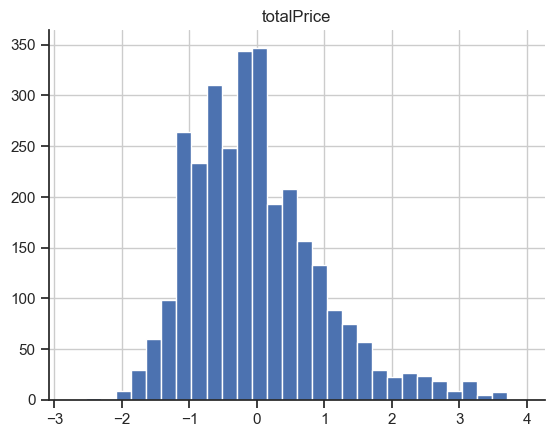

In [15]:
y_train.hist(bins=30)
plt.show()

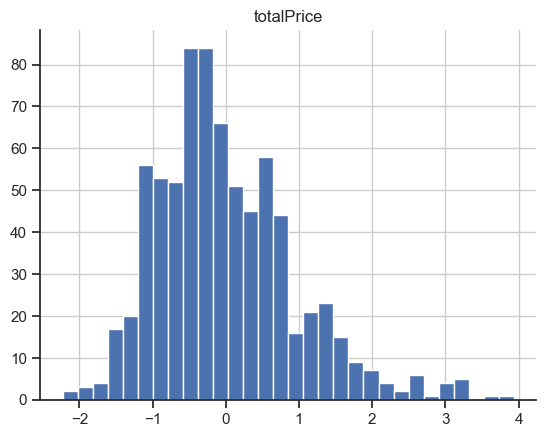

In [16]:
y_test.hist(bins=30)
plt.show()

In [17]:
feature_missing_imputer = CategoricalImputer(
    imputation_method="missing",
    fill_value="Missing",
    variables=MISSING_IMPUTER_FEATURES,
)
feature_missing_imputer.fit(X_train)

X_train = feature_missing_imputer.transform(X_train)
X_test = feature_missing_imputer.transform(X_test)

In [18]:
feature_mode_imputer = CategoricalImputer(
    imputation_method="frequent",
    variables=MODE_IMPUTER_FEATURES,
)
feature_mode_imputer.fit(X_train)

X_train = feature_mode_imputer.transform(X_train)
X_test = feature_mode_imputer.transform(X_test)

In [19]:
feature_rare_label_encoder = RareLabelEncoder(
    n_categories=1,
    tol=0.01,
    variables=CATEGORICAL_FEATURES,
)
feature_rare_label_encoder.fit(X_train)

X_train = feature_rare_label_encoder.transform(X_train)
X_test = feature_rare_label_encoder.transform(X_test)

In [20]:
feature_ordinal_encoder = OrdinalEncoder(encoding_method="ordered", variables=ORDINAL_ENCODER_FEATURES)
feature_ordinal_encoder.fit(X_train, y_train.squeeze())

X_train = feature_ordinal_encoder.transform(X_train)
X_test = feature_ordinal_encoder.transform(X_test)

In [21]:
proximity_score_generator = ProximityScoreGenerator(variables=PROXIMITY_FEATURES)
proximity_score_generator.fit(X_train)

X_train = proximity_score_generator.transform(X_train)
X_test = proximity_score_generator.transform(X_test)

In [22]:
relative_feature_generator = RelativeFeatureGenerator(variables=RELATIVE_FEATURES)
relative_feature_generator.fit(X_train)

X_train = relative_feature_generator.transform(X_train)
X_test = relative_feature_generator.transform(X_test)

In [23]:
feature_dropper = DropFeatures(features_to_drop=FEATURES_TO_DROP)
feature_dropper.fit(X_train)

X_train = feature_dropper.transform(X_train)
X_test = feature_dropper.transform(X_test)

In [24]:
X_train.head()

,floor,propertyType,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,status,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,hasSwimmingPool,hasBalcony,hasGarage,hasParking,hasAirConditioning,hasClotheslineSpace,hasBuiltInWardrobes,hasDishwasher,hasWashingMachine,hasDryer,hasElevator,isFurnished,isPetFriendly,isSmokingAllowed,isWheelchairAccessible,hasGarden,hasFireplace,hasAlarmSystem,hasCityViews,hasWaterViews,isLuxury,isTemporaryContract,isLongTermContract,isStudentFriendly,energyEfficiencyRating,hasHomeAppliances,hasOven,hasMicrowave,hasRefrigerator,hasStove,hasTerrace,hasStorageRoom,hasInternetIncluded,hasCableTVIncluded,hasSmartHomeFeatures,hasCCTV,hasGym,isNewlyRenovated,hasModernFinish,proximityToTransportScore,proximityToGreenSpaceScore,relativePriceByArea,listingsDensityScore
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34015775,8,flat,80.0,1,1,10,15,38.723343,-9.165523,False,True,good,False,True,True,False,False,False,False,False,NaN,False,False,False,4066.998507,367.170915,12,1303.750915,10,2025.041852,11,435.583417,16,1022.889453,12,1288.987386,18,1561.932797,13,532.206611,12,21.207530,1,625.332667,2,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,0.839990,0.752630,0.351981,1.000000
33921562,1,flat,11.0,1,1,15,5,38.716879,-9.133739,False,False,good,False,False,False,False,False,False,False,False,False,False,False,False,1408.758350,200.241176,7,967.993149,12,434.433265,7,197.812157,11,1968.143427,11,251.595488,17,248.418082,9,148.408202,16,297.018100,1,138.226478,8,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,True,False,False,False,False,False,False,True,True,False,False,False,False,False,0.926463,0.949489,2.086796,0.033742
32469605,1,flat,108.0,2,2,1,14,38.768539,-9.107836,False,True,good,False,True,True,False,False,False,False,False,NaN,False,True,True,9293.252976,917.898041,13,984.097450,8,1963.732949,8,881.267079,16,3467.395360,10,851.595933,26,2496.742638,12,518.356192,9,120.579475,1,6920.695870,3,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,5,True,True,False,True,False,False,True,False,False,False,False,False,False,True,0.532305,0.577444,0.824849,0.588957
34012458,1,flat,64.0,2,1,21,35,38.704105,-9.167048,False,False,good,False,True,False,False,False,False,False,False,NaN,False,False,False,3537.760924,2551.467645,26,775.824745,11,1270.282497,5,478.909308,33,1328.348997,6,2337.518158,32,476.826348,18,459.662367,26,120.223034,1,112.716402,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0,False,False,False,False,False,False,False,True,True,False,False,False,False,False,0.834150,0.884832,1.551905,0.185583
33828785,5,flat,40.0,1,1,19,31,38.736815,-9.143016,False,False,good,False,True,False,False,False,False,False,False,False,False,False,False,4321.526269,203.134125,16,1267.982833,9,817.311697,9,143.209453,16,482.209903,13,345.138822,28,1551.547284,8,144.857858,23,131.764658,1,2153.330866,6,False,False,False,False,False,False,False,Fal

In [25]:
feature_one_hot_encoder = OneHotEncoder(drop_last=True, variables=ONE_HOT_ENCODER_FEATURES)
feature_one_hot_encoder.fit(X_train)

X_train = feature_one_hot_encoder.transform(X_train)
X_test = feature_one_hot_encoder.transform(X_test)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3018 entries, 34015775 to 33921277
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          3018 non-null   int64  
 1   size                           3018 non-null   float64
 2   rooms                          3018 non-null   int64  
 3   bathrooms                      3018 non-null   int64  
 4   municipality                   3018 non-null   int64  
 5   district                       3018 non-null   int64  
 6   latitude                       3018 non-null   float64
 7   longitude                      3018 non-null   float64
 8   showAddress                    3018 non-null   bool   
 9   hasVideo                       3018 non-null   bool   
 10  newDevelopment                 3018 non-null   bool   
 11  hasLift                        2995 non-null   object 
 12  hasPlan                        3018 non-nu

In [27]:
feature_yeo_johnson_transformer = YeoJohnsonTransformer(variables=YEO_JOHNSON_TRANSFORMER_FEATURES)
feature_yeo_johnson_transformer.fit(X_train)

X_train = feature_yeo_johnson_transformer.transform(X_train)
X_test = feature_yeo_johnson_transformer.transform(X_test)

In [28]:
X_train.head()

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,hasSwimmingPool,hasBalcony,hasGarage,hasParking,hasAirConditioning,hasClotheslineSpace,hasBuiltInWardrobes,hasDishwasher,hasWashingMachine,hasDryer,hasElevator,isFurnished,isPetFriendly,isSmokingAllowed,isWheelchairAccessible,hasGarden,hasFireplace,hasAlarmSystem,hasCityViews,hasWaterViews,isLuxury,isTemporaryContract,isLongTermContract,isStudentFriendly,energyEfficiencyRating,hasHomeAppliances,hasOven,hasMicrowave,hasRefrigerator,hasStove,hasTerrace,hasStorageRoom,hasInternetIncluded,hasCableTVIncluded,hasSmartHomeFeatures,hasCCTV,hasGym,isNewlyRenovated,hasModernFinish,proximityToTransportScore,proximityToGreenSpaceScore,relativePriceByArea,listingsDensityScore,propertyType_flat,propertyType_duplex,propertyType_studio,propertyType_Rare,status_good
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34015775,8,4.954393,1,1,10,15,38.723343,-9.165523,False,True,False,True,True,False,False,False,False,False,NaN,False,False,False,42.589737,10.556419,12,13.987595,10,33.784022,11,30.506914,16,19.541967,12,5.802565,18,11.672516,13,28.753861,12,7.207695,1,7.155169,2,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,0.839990,0.752630,0.351981,1.000000,1,0,0,0,1
33921562,1,2.657768,1,1,15,5,38.716879,-9.133739,False,False,False,False,False,False,False,False,False,False,False,False,False,False,29.305038,8.893482,7,13.010589,12,19.231732,7,20.941711,11,23.889344,11,4.695041,17,7.761496,9,16.212105,16,30.569232,1,5.349413,8,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,True,False,False,False,False,False,False,True,True,False,False,False,False,False,0.926463,0.949489,2.086796,0.033742,1,0,0,0,1
32469605,1,5.333039,2,2,1,14,38.768539,-9.107836,False,True,False,True,True,False,False,False,False,False,NaN,False,True,True,56.626102,13.446218,13,13.063441,8,33.415875,8,42.355425,16,28.300066,10,5.531652,26,12.814074,12,28.423877,9,19.069153,1,10.227626,3,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,5,True,True,False,True,False,False,True,False,False,False,False,False,False,True,0.532305,0.577444,0.824849,0.588957,1,0,0,0,1
34012458,1,4.677597,2,1,21,35,38.704105,-9.167048,False,False,False,True,False,False,False,False,False,False,NaN,False,False,False,40.571093,17.291715,26,12.315895,11,28.578618,5,31.895887,33,21.189131,6,6.179964,32,9.051809,18,26.963868,26,19.039105,1,5.112974,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0,False,False,False,False,False,False,False,True,True,False,False,False,False,False,0.834150,0.884832,1.551905,0.185583,1,0,0,0,1
33828785,5,4.108437,1,1,19,31,38.736815,-9.143016,False,False,False,True,False,False,False,False,False,False,False,False,False,False,43.497654,8.930720,16,13.894215,9,24.336188,9,17.891760,16,15.384309,13,4.917701,28,11.656730,8,16.031579,23,19.989972,1,8.705335,6,False,False,False,False,False,False,False,False,False,F

In [29]:
feature_frequent_value_amputer = FrequentValueAmputer(variables=FREQUENT_VALUE_AMPUTER_FEATURES, threshold=0.04)
feature_frequent_value_amputer.fit(X_train)

X_train = feature_frequent_value_amputer.transform(X_train)
X_test = feature_frequent_value_amputer.transform(X_test)

In [30]:
feature_frequent_value_amputer.frequent_values

{'size': [4.376255599890183, 2.6577675639584095]}

In [31]:
X_train.head()

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,hasSwimmingPool,hasBalcony,hasGarage,hasParking,hasAirConditioning,hasClotheslineSpace,hasBuiltInWardrobes,hasDishwasher,hasWashingMachine,hasDryer,hasElevator,isFurnished,isPetFriendly,isSmokingAllowed,isWheelchairAccessible,hasGarden,hasFireplace,hasAlarmSystem,hasCityViews,hasWaterViews,isLuxury,isTemporaryContract,isLongTermContract,isStudentFriendly,energyEfficiencyRating,hasHomeAppliances,hasOven,hasMicrowave,hasRefrigerator,hasStove,hasTerrace,hasStorageRoom,hasInternetIncluded,hasCableTVIncluded,hasSmartHomeFeatures,hasCCTV,hasGym,isNewlyRenovated,hasModernFinish,proximityToTransportScore,proximityToGreenSpaceScore,relativePriceByArea,listingsDensityScore,propertyType_flat,propertyType_duplex,propertyType_studio,propertyType_Rare,status_good
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34015775,8,4.954393,1,1,10,15,38.723343,-9.165523,False,True,False,True,True,False,False,False,False,False,NaN,False,False,False,42.589737,10.556419,12,13.987595,10,33.784022,11,30.506914,16,19.541967,12,5.802565,18,11.672516,13,28.753861,12,7.207695,1,7.155169,2,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,0.839990,0.752630,0.351981,1.000000,1,0,0,0,1
33921562,1,NaN,1,1,15,5,38.716879,-9.133739,False,False,False,False,False,False,False,False,False,False,False,False,False,False,29.305038,8.893482,7,13.010589,12,19.231732,7,20.941711,11,23.889344,11,4.695041,17,7.761496,9,16.212105,16,30.569232,1,5.349413,8,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,True,False,False,False,False,False,False,True,True,False,False,False,False,False,0.926463,0.949489,2.086796,0.033742,1,0,0,0,1
32469605,1,5.333039,2,2,1,14,38.768539,-9.107836,False,True,False,True,True,False,False,False,False,False,NaN,False,True,True,56.626102,13.446218,13,13.063441,8,33.415875,8,42.355425,16,28.300066,10,5.531652,26,12.814074,12,28.423877,9,19.069153,1,10.227626,3,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,5,True,True,False,True,False,False,True,False,False,False,False,False,False,True,0.532305,0.577444,0.824849,0.588957,1,0,0,0,1
34012458,1,4.677597,2,1,21,35,38.704105,-9.167048,False,False,False,True,False,False,False,False,False,False,NaN,False,False,False,40.571093,17.291715,26,12.315895,11,28.578618,5,31.895887,33,21.189131,6,6.179964,32,9.051809,18,26.963868,26,19.039105,1,5.112974,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0,False,False,False,False,False,False,False,True,True,False,False,False,False,False,0.834150,0.884832,1.551905,0.185583,1,0,0,0,1
33828785,5,4.108437,1,1,19,31,38.736815,-9.143016,False,False,False,True,False,False,False,False,False,False,False,False,False,False,43.497654,8.930720,16,13.894215,9,24.336188,9,17.891760,16,15.384309,13,4.917701,28,11.656730,8,16.031579,23,19.989972,1,8.705335,6,False,False,False,False,False,False,False,False,False,False,

In [32]:
# Apply AddMissingIndicator
feature_missing_indicator = AddMissingIndicator()
feature_missing_indicator.fit(X_train)

X_train = feature_missing_indicator.transform(X_train)
X_test = feature_missing_indicator.transform(X_test)

In [33]:
feature_standard_scaler = SklearnTransformerWrapper(
    transformer=StandardScaler(),
    variables=STANDARD_SCALER_FEATURES,
)
feature_standard_scaler.fit(X_train)

X_train = feature_standard_scaler.transform(X_train)
X_test = feature_standard_scaler.transform(X_test)

In [34]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [35]:
# Apply KNNImputer
feature_knn_imputer = SklearnTransformerWrapper(
    transformer=KNNImputer(n_neighbors=5, weights="distance"),
    variables=KNN_IMPUTER_FEATURES,
)
feature_knn_imputer.fit(X_train)

X_train = feature_knn_imputer.transform(X_train)
X_test = feature_knn_imputer.transform(X_test)

In [36]:
feature_gaussian_outlier_trimmer = OutlierTrimmer(
    capping_method="gaussian",
    tail="both",
    fold=3,
    variables=GAUSSIAN_OUTLIER_REMOVER_FEATURES,
)
feature_gaussian_outlier_trimmer.fit(X_train)

X_train, y_train = feature_gaussian_outlier_trimmer.transform_x_y(X_train, y_train)
X_test, y_test = feature_gaussian_outlier_trimmer.transform_x_y(X_test, y_test)

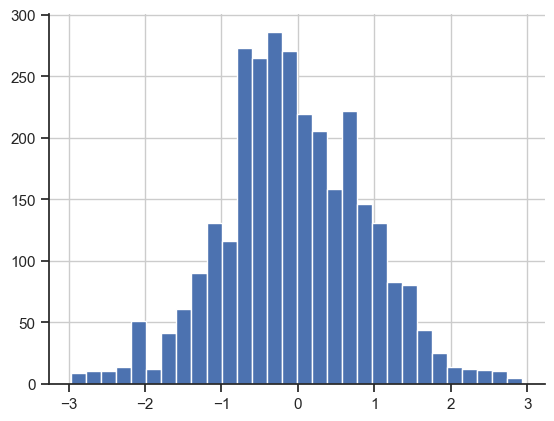

In [37]:
X_train["size"].hist(bins=30)
plt.show()

In [38]:
# feature_iqr_outlier_trimmer = OutlierTrimmer(
#     capping_method="iqr",
#     tail="both",
#     fold=1.5,
#     variables=IQR_OUTLIER_REMOVER_FEATURES,
# )
# feature_iqr_outlier_trimmer.fit(X_train)

# X_train, y_train = feature_iqr_outlier_trimmer.transform_x_y(X_train, y_train)
# X_test, y_test = feature_iqr_outlier_trimmer.transform_x_y(X_test, y_test)

In [39]:
# feature_rare_value_trimmer = RareValueTrimmer(
#     threshold=0.01,
#     variables=RARE_VALUE_OUTLIER_REMOVER_FEATURES,
# )
# feature_rare_value_trimmer.fit(X_train)

# X_train, y_train = feature_rare_value_trimmer.transform_x_y(X_train, y_train)
# X_test, y_test = feature_rare_value_trimmer.transform_x_y(X_test, y_test)

In [40]:
X_train.head()

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,hasSwimmingPool,hasBalcony,hasGarage,hasParking,hasAirConditioning,hasClotheslineSpace,hasBuiltInWardrobes,hasDishwasher,hasWashingMachine,hasDryer,hasElevator,isFurnished,isPetFriendly,isSmokingAllowed,isWheelchairAccessible,hasGarden,hasFireplace,hasAlarmSystem,hasCityViews,hasWaterViews,isLuxury,isTemporaryContract,isLongTermContract,isStudentFriendly,energyEfficiencyRating,hasHomeAppliances,hasOven,hasMicrowave,hasRefrigerator,hasStove,hasTerrace,hasStorageRoom,hasInternetIncluded,hasCableTVIncluded,hasSmartHomeFeatures,hasCCTV,hasGym,isNewlyRenovated,hasModernFinish,proximityToTransportScore,proximityToGreenSpaceScore,relativePriceByArea,listingsDensityScore,propertyType_flat,propertyType_duplex,propertyType_studio,propertyType_Rare,status_good,size_na,hasLift_na,newDevelopmentFinished_na
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34015775,2.171421,-0.122825,-0.831570,-0.698983,-0.356745,-0.334801,-0.283104,-0.619896,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053817,-0.580685,-0.352357,0.296038,0.509170,0.953904,0.626144,0.263848,-0.158508,-0.269680,1.043037,0.695785,-0.039727,0.618243,0.475881,0.693352,-0.292067,-2.117835,0.111409,-0.124521,-1.345872,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.839990,0.752630,0.351981,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
33921562,-0.757356,-0.590529,-0.831570,-0.698983,0.453990,-1.387330,-0.596209,0.685112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.268537,-1.229188,-1.074981,-0.155409,0.973843,-0.963897,-0.252073,-0.941289,-0.720909,0.684852,0.755348,-1.076787,-0.140228,-1.274732,-0.315092,-1.185731,0.215028,1.775122,0.111409,-1.107276,0.345857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.926463,0.949489,2.086796,0.033742,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
32469605,-0.757356,0.404546,0.046247,0.486813,-1.816069,-0.440054,1.905806,1.748657,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.450991,0.546263,-0.207832,-0.130987,0.044497,0.905387,-0.032518,1.756664,-0.158508,1.653293,0.467660,0.262194,0.764279,1.170769,0.278138,0.643912,-0.672389,-0.141246,0.111409,1.547619,-1.063917,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.532305,0.577444,0.824849,0.588957,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
34012458,-0.757356,-0.508340,0.046247,-0.698983,1.426873,1.770259,-1.214853,-0.682498,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.147118,2.045908,1.670990,-0.476408,0.741506,0.267900,-0.691181,0.438847,1.753654,0.091979,-0.683093,1.299805,1.367284,-0.650207,1.464596,0.425164,1.482767,-0.146253,0.111409,-1.235955,0.345857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.834150,0.884832,1.551905,0.185583,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
33828785,0.916231,-1.301055,-0.831570,-0.698983,1.102579,1.349247,0.369332,0.304197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [41]:
X_train.shape

(3004, 94)

In [42]:
from sklearn.preprocessing import PolynomialFeatures

# Create a transformer that only computes interaction terms (degree=2)
polynomial_feature_generator = SklearnTransformerWrapper(
    transformer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

# Generate the interaction terms for X_train
polynomial_feature_generator.fit(X_train)

X_train = polynomial_feature_generator.transform(X_train)
X_test = polynomial_feature_generator.transform(X_test)

In [43]:
unary_feature_dropper = UnaryFeatureDropper()
unary_feature_dropper.fit(X_train)

X_train, y_train = unary_feature_dropper.transform_x_y(X_train, y_train)
X_test, y_test = unary_feature_dropper.transform_x_y(X_test, y_test)

In [44]:
feature_selector = SelectFromModel(Lasso(alpha=0.01, random_state=42, max_iter=10000))

# train Lasso model and select features
feature_selector.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.01, max_iter=10000, random_state=42))

In [45]:
# this is how we can make a list of the selected features
selected_feats = X_train.columns[(feature_selector.get_support())].to_list()
dropped_feats = X_train.columns[(~feature_selector.get_support())].to_list()

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_selector.estimator_.coef_ == 0)))

total features: 4003
selected features: 126
features with coefficients shrank to zero: 3877


In [46]:
selected_feats

['floor',
 'size',
 'rooms',
 'bathrooms',
 'municipality',
 'district',
 'latitude',
 'distanceToCityCenter',
 'distanceToNearestTrain',
 'nearestTrainName',
 'nearestFairName',
 'nearestParkName',
 'nearestViewpointName',
 'nearestPlaygroundName',
 'distanceToNearestTram',
 'nearestTramName',
 'hasSwimmingPool',
 'hasAirConditioning',
 'hasStove',
 'relativePriceByArea',
 'floor size',
 'floor latitude',
 'floor distanceToCityCenter',
 'floor nearestParkName',
 'floor distanceToNearestPlayground',
 'floor distanceToNearestBus',
 'floor nearestBusName',
 'floor nearestTramName',
 'floor hasHomeAppliances',
 'floor relativePriceByArea',
 'floor propertyType_flat',
 'size bathrooms',
 'size distanceToNearestMall',
 'size distanceToNearestTrain',
 'size nearestMarketName',
 'size distanceToNearestMetro',
 'size isFurnished',
 'size energyEfficiencyRating',
 'size relativePriceByArea',
 'size listingsDensityScore',
 'size size_na',
 'rooms bathrooms',
 'rooms longitude',
 'rooms nearestMa

In [47]:
dropped_feats

['longitude',
 'showAddress',
 'hasVideo',
 'newDevelopment',
 'hasLift',
 'hasPlan',
 'has3DTour',
 'has360',
 'hasStaging',
 'newDevelopmentFinished',
 'hasParkingSpace',
 'isParkingSpaceIncludedInPrice',
 'distanceToNearestMall',
 'nearestMallName',
 'distanceToNearestFair',
 'distanceToNearestPark',
 'distanceToNearestMarket',
 'nearestMarketName',
 'distanceToNearestMetro',
 'nearestMetroName',
 'distanceToNearestViewpoint',
 'distanceToNearestPlayground',
 'distanceToNearestBus',
 'nearestBusName',
 'hasBalcony',
 'hasGarage',
 'hasParking',
 'hasClotheslineSpace',
 'hasBuiltInWardrobes',
 'hasDishwasher',
 'hasWashingMachine',
 'hasDryer',
 'hasElevator',
 'isFurnished',
 'isPetFriendly',
 'isSmokingAllowed',
 'isWheelchairAccessible',
 'hasGarden',
 'hasFireplace',
 'hasAlarmSystem',
 'hasCityViews',
 'hasWaterViews',
 'isLuxury',
 'isTemporaryContract',
 'isLongTermContract',
 'isStudentFriendly',
 'energyEfficiencyRating',
 'hasHomeAppliances',
 'hasOven',
 'hasMicrowave',
 '

In [48]:
X_train = X_train[selected_feats]
X_test = X_test[selected_feats]

In [49]:
correlation = pd.concat([X_train, y_train], axis=1).corr()[TARGET].sort_values(by=TARGET, ascending=False)
correlation

,totalPrice
totalPrice,1.000000
size,0.657339
bathrooms,0.639427
rooms,0.541073
rooms hasHomeAppliances,0.502145
bathrooms isParkingSpaceIncludedInPrice,0.459884
bathrooms relativePriceByArea,0.426474
size isFurnished,0.413374
size listingsDensityScore,0.409613
size bathrooms,0.403579


In [50]:
def plot_residuals(model, X_train, y_train, X_test, y_test, target_transformer=None):
    """
    Fits the model on the training data, predicts on both training and test sets,
    optionally applies an inverse transformation to the target values, calculates residuals,
    and plots the residuals for both datasets.

    Parameters:
    - model: A regression model with fit() and predict() methods.
    - X_train: Training features.
    - y_train: Training target values.
    - X_test: Test features.
    - y_test: Test target values.
    - target_transformer: (Optional) A transformer (e.g., from sklearn.preprocessing) with an inverse_transform() method.
                          Defaults to None.
    """

    # Generate predictions as pandas DataFrame
    y_train_pred = pd.DataFrame(
        data=model.predict(X_train).squeeze(),
        columns=TARGET,
        index=X_train.index,
    )
    y_test_pred = pd.DataFrame(
        data=model.predict(X_test).squeeze(),
        columns=TARGET,
        index=X_test.index,
    )

    # If a target_transformer is provided, inverse transform both actual and predicted targets.
    if target_transformer is not None:
        y_train = target_transformer.inverse_transform(pd.DataFrame(y_train))
        y_test = target_transformer.inverse_transform(pd.DataFrame(y_test))
        y_train_pred = target_transformer.inverse_transform(y_train_pred)
        y_test_pred = target_transformer.inverse_transform(y_test_pred)

    # Calculate residuals: actual - predicted
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Create subplots for training and test residuals
    _, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training residuals
    ax[0].scatter(y_train_pred, train_residuals, alpha=0.1, color="blue")
    ax[0].axhline(0, color="red", linestyle="--")
    ax[0].set_title("Training Residuals")
    ax[0].set_xlabel("Predicted Values")
    ax[0].set_ylabel("Residuals")

    # Plot test residuals
    ax[1].scatter(y_test_pred, test_residuals, alpha=0.1, color="green")
    ax[1].axhline(0, color="red", linestyle="--")
    ax[1].set_title("Test Residuals")
    ax[1].set_xlabel("Predicted Values")
    ax[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

In [51]:
def plot_true_vs_pred(model, X_train, y_train, X_test, y_test, target_transformer=None):
    """
    Fits the model on the training data, predicts on both training and test sets,
    optionally applies an inverse transformation to the target values, plots the
    true vs. predicted target values for both datasets, and displays the R2 and MAE metrics.

    Parameters:
    - model: A regression model with fit() and predict() methods.
    - X_train: Training features.
    - y_train: Training target values.
    - X_test: Test features.
    - y_test: Test target values.
    - target_transformer: (Optional) A transformer (e.g., from sklearn.preprocessing)
      with an inverse_transform() method. Defaults to None.
    """

    # Generate predictions as pandas DataFrame
    y_train_pred = pd.DataFrame(
        data=model.predict(X_train).squeeze(),
        columns=TARGET,
        index=X_train.index,
    )
    y_test_pred = pd.DataFrame(
        data=model.predict(X_test).squeeze(),
        columns=TARGET,
        index=X_test.index,
    )

    # If a target_transformer is provided, inverse transform both actual and predicted targets.
    if target_transformer is not None:
        y_train = target_transformer.inverse_transform(pd.DataFrame(y_train))
        y_test = target_transformer.inverse_transform(pd.DataFrame(y_test))
        y_train_pred = target_transformer.inverse_transform(y_train_pred)
        y_test_pred = target_transformer.inverse_transform(y_test_pred)

    # Convert targets and predictions to numpy arrays and flatten for metric calculations.
    y_train_true = np.asarray(y_train).flatten()
    y_train_pred_val = np.asarray(y_train_pred).flatten()
    y_test_true = np.asarray(y_test).flatten()
    y_test_pred_val = np.asarray(y_test_pred).flatten()

    # Compute metrics
    r2_train = r2_score(y_train_true, y_train_pred_val)
    mae_train = mean_absolute_error(y_train_true, y_train_pred_val)
    r2_test = r2_score(y_test_true, y_test_pred_val)
    mae_test = mean_absolute_error(y_test_true, y_test_pred_val)

    # Use np.min and np.max to extract scalar min and max values for the ideal line.
    train_min = min(np.min(y_train_true), np.min(y_train_pred_val))
    train_max = max(np.max(y_train_true), np.max(y_train_pred_val))
    test_min = min(np.min(y_test_true), np.min(y_test_pred_val))
    test_max = max(np.max(y_test_true), np.max(y_test_pred_val))

    # Create subplots for training and test true vs. predicted plots
    _, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot true vs. predicted for training data
    ax[0].scatter(y_train_true, y_train_pred_val, alpha=0.1, color="blue")
    ax[0].plot([train_min, train_max], [train_min, train_max], color="red", linestyle="--")
    ax[0].set_title("Training: True vs. Predicted")
    ax[0].set_xlabel("True Values")
    ax[0].set_ylabel("Predicted Values")
    # Display training metrics on the plot
    ax[0].text(0.05, 0.95, f"R² = {r2_train:.3f}\nMAE = {mae_train:.3f}", 
               transform=ax[0].transAxes, verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.1))

    # Plot true vs. predicted for test data
    ax[1].scatter(y_test_true, y_test_pred_val, alpha=0.1, color="green")
    ax[1].plot([test_min, test_max], [test_min, test_max], color="red", linestyle="--")
    ax[1].set_title("Test: True vs. Predicted")
    ax[1].set_xlabel("True Values")
    ax[1].set_ylabel("Predicted Values")
    # Display test metrics on the plot
    ax[1].text(0.05, 0.95, f"R² = {r2_test:.3f}\nMAE = {mae_test:.3f}", 
               transform=ax[1].transAxes, verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.1))

    plt.tight_layout()
    plt.show()

In [52]:
X_train_dev, X_val, y_train_dev, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [53]:
linear_model = LinearRegression()
linear_model.fit(X_train_dev, y_train_dev)

LinearRegression()

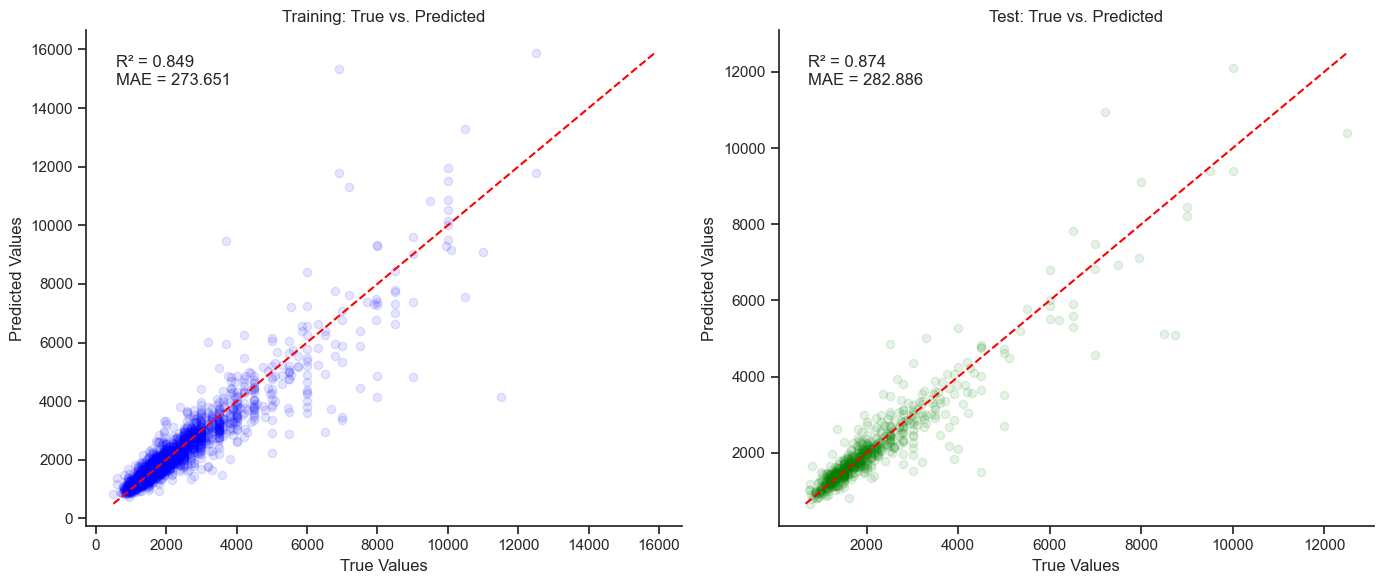

In [54]:
plot_true_vs_pred(linear_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=target_transformer_pipeline,)

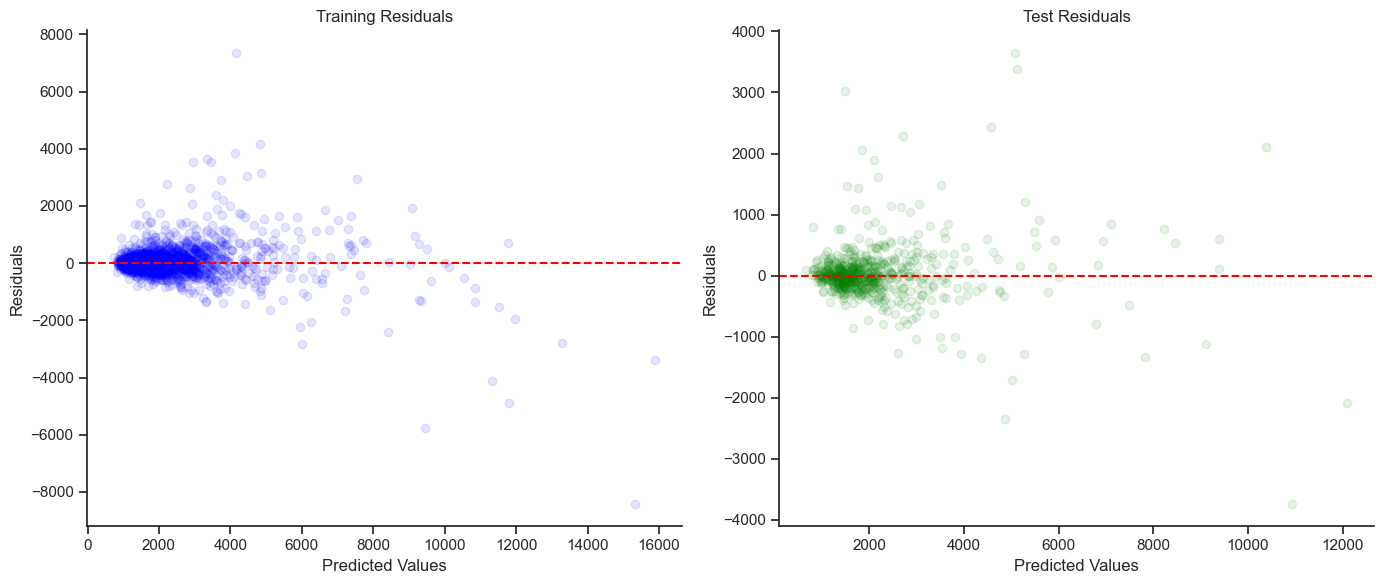

In [55]:
plot_residuals(linear_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=target_transformer_pipeline,)

In [56]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

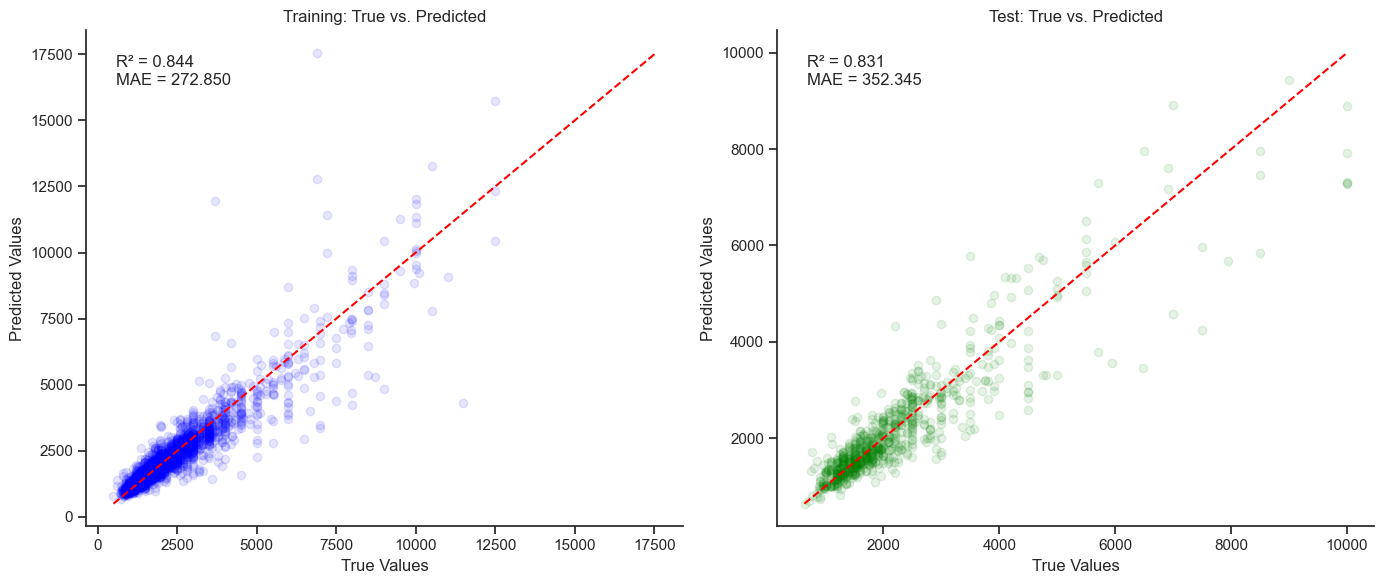

In [57]:
plot_true_vs_pred(linear_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

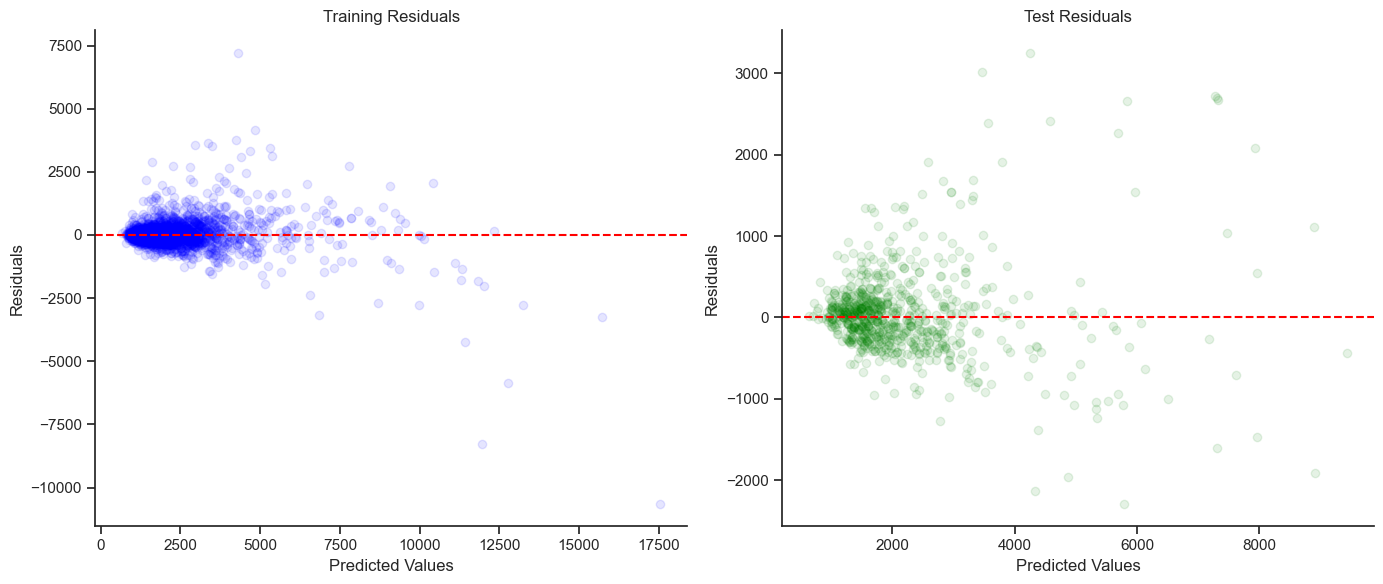

In [58]:
plot_residuals(linear_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

In [59]:
elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net_model.fit(X_train_dev, y_train_dev)

ElasticNet(alpha=0.001, max_iter=10000, random_state=42)

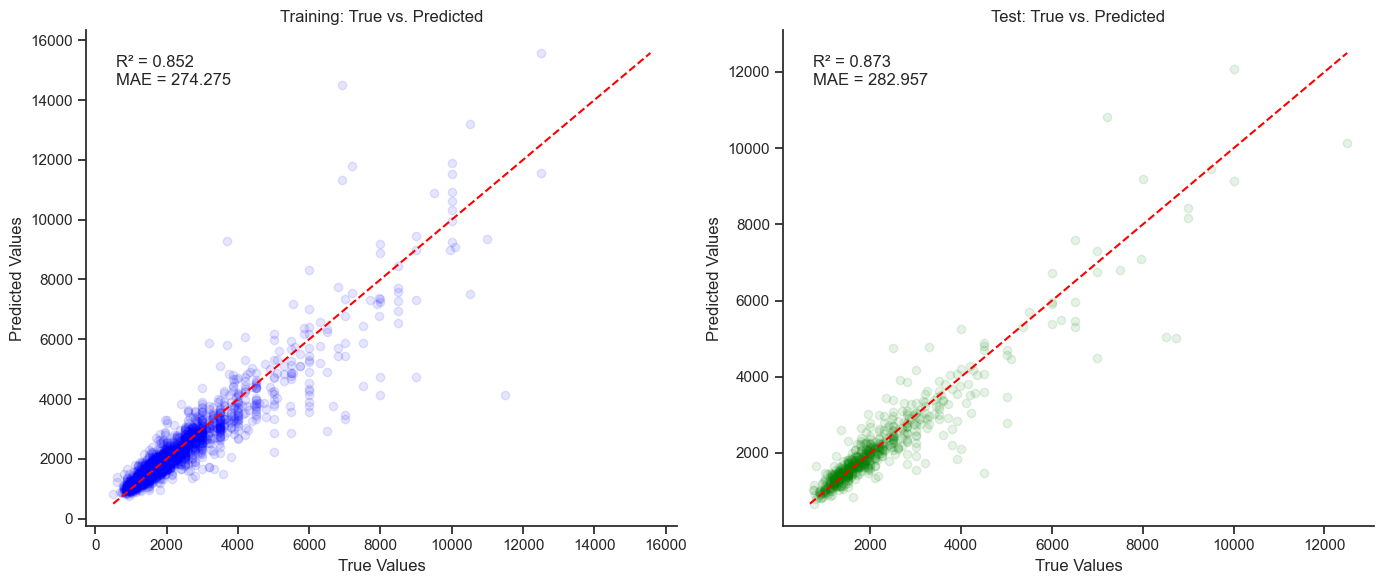

In [60]:
plot_true_vs_pred(elastic_net_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=target_transformer_pipeline,)

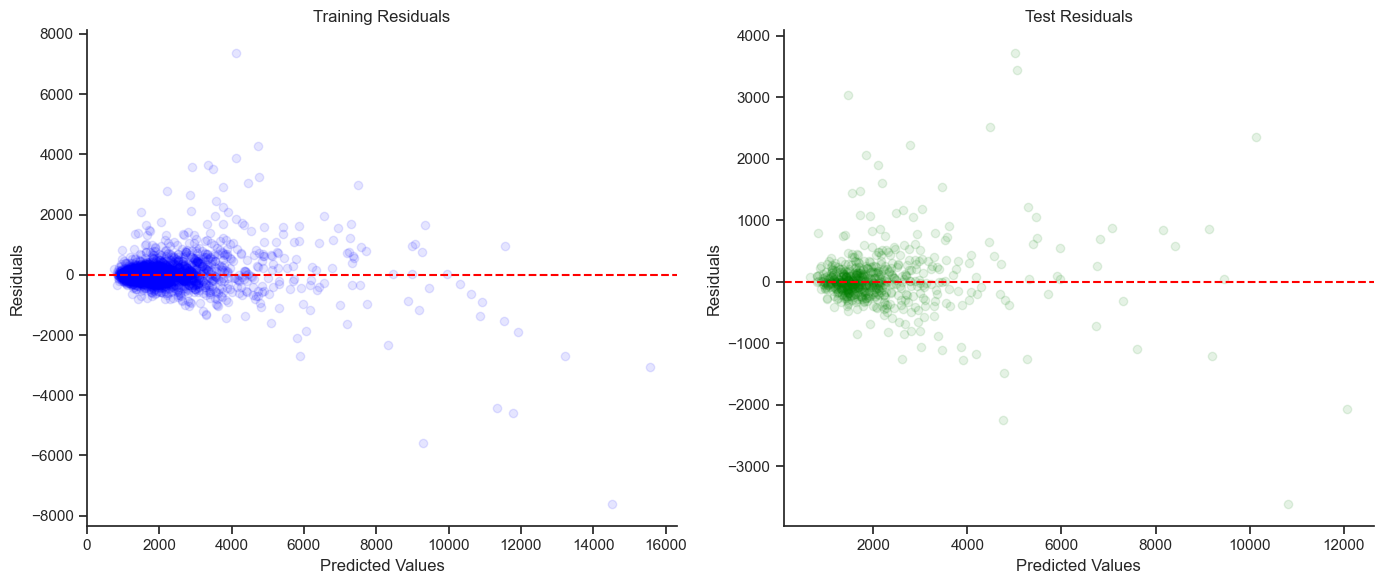

In [61]:
plot_residuals(elastic_net_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=target_transformer_pipeline,)

In [62]:
elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.001, max_iter=10000, random_state=42)

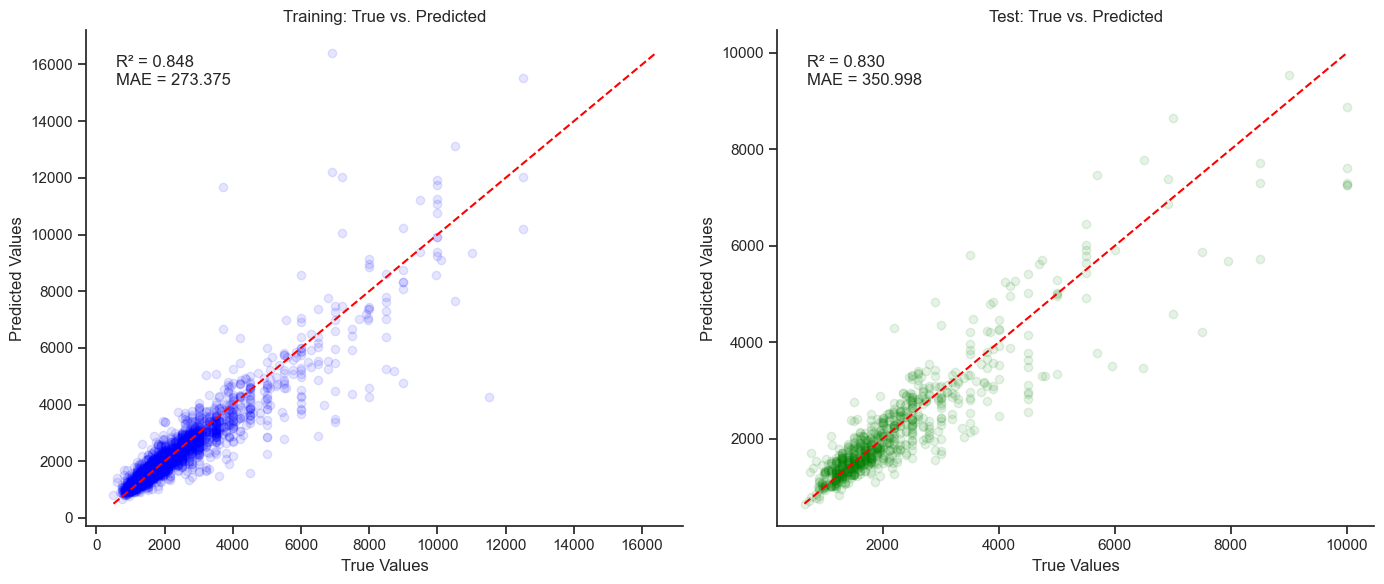

In [63]:
plot_true_vs_pred(elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

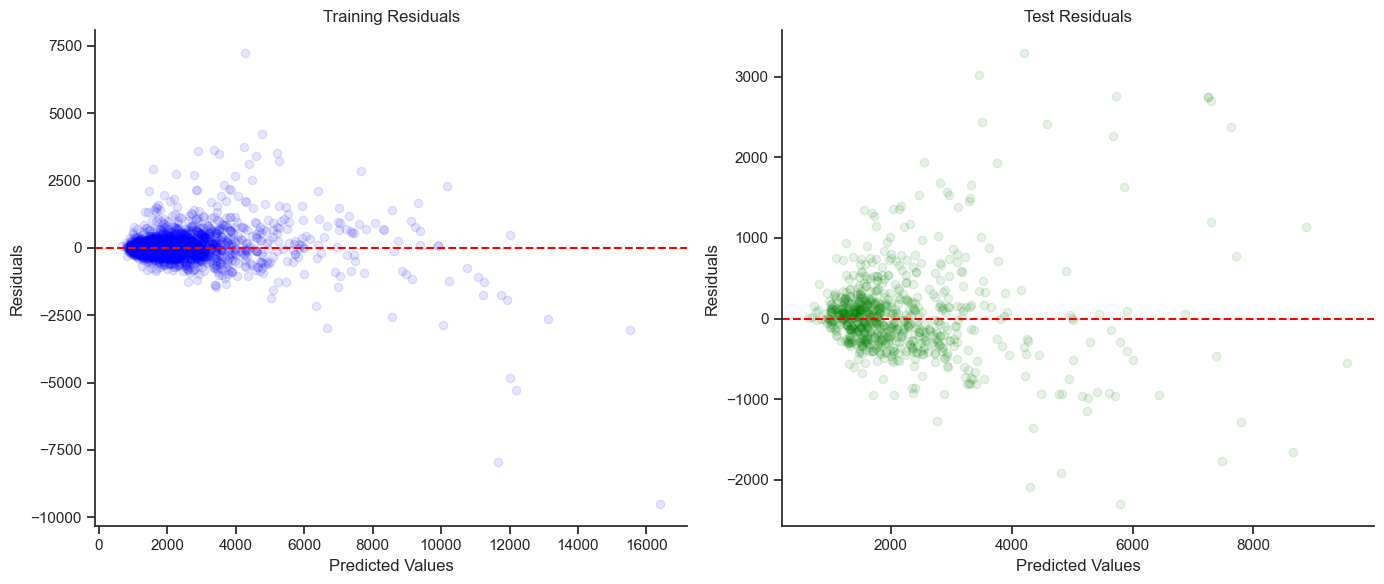

In [64]:
plot_residuals(elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

In [65]:
from sklearn.model_selection import GridSearchCV

# Define the Elastic Net model
model = ElasticNet(max_iter=100000)

# Parameter grid to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],   # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],   # L1/L2 mixing
}

# Grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_)}")

Best alpha: 0.001
Best l1_ratio: 0.7
Best RMSE: 0.3494741965274872


In [66]:
improved_elastic_net_model = ElasticNet(**grid_search.best_params_, random_state=42)
improved_elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42)

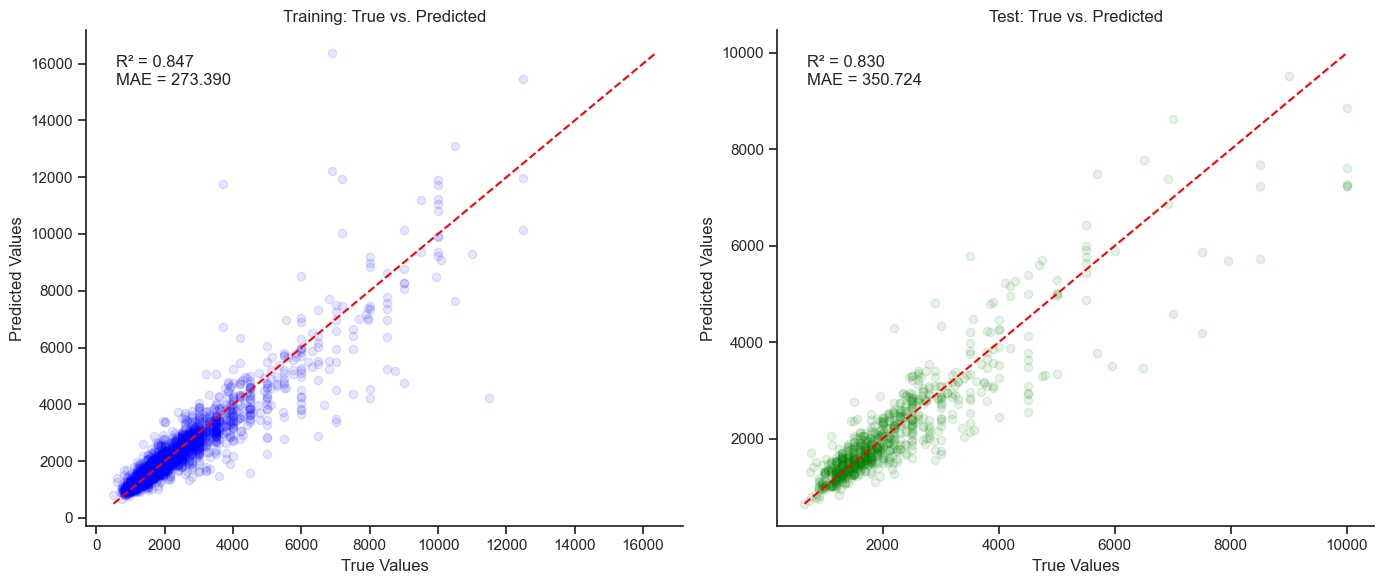

In [67]:
plot_true_vs_pred(improved_elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

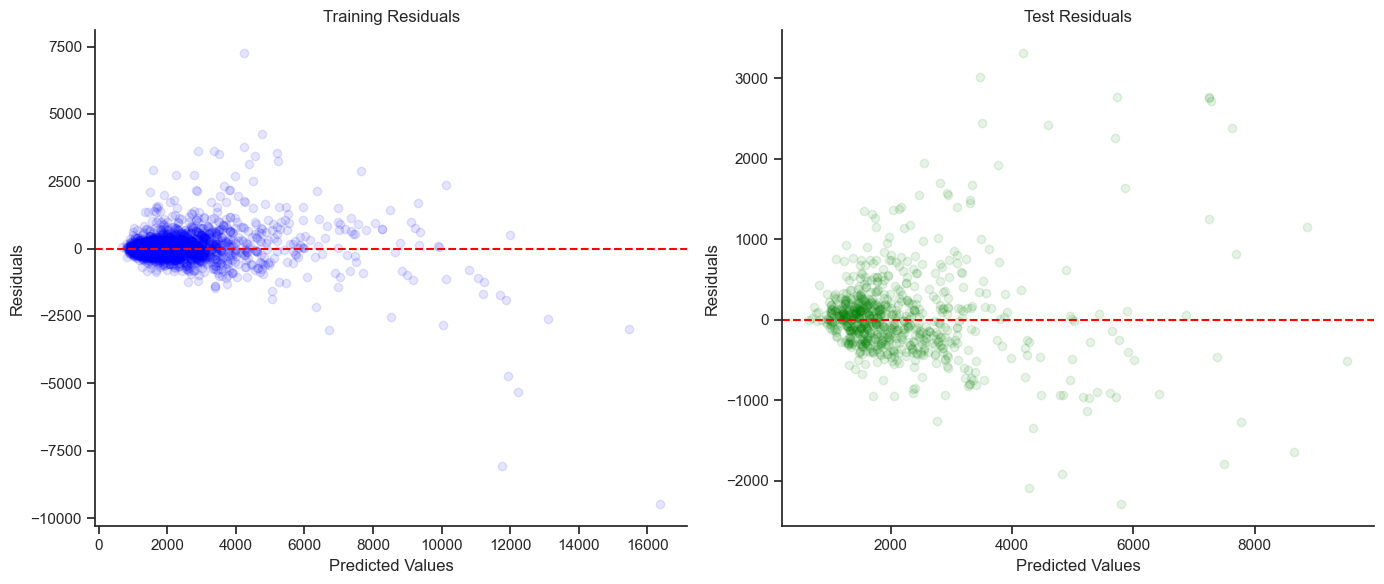

In [68]:
plot_residuals(improved_elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

In [69]:
selected_feature_indices = np.where(improved_elastic_net_model.coef_ != 0)[0]
dropped_feature_indices = np.where(improved_elastic_net_model.coef_ == 0)[0]

# this is how we can make a list of the selected features
selected_features = X_train.columns[selected_feature_indices].to_list()
dropped_features = X_train.columns[dropped_feature_indices].to_list()

# let's print some stats
print("total features: {}".format((X_train.shape[1])))
print("selected features: {}".format(len(selected_features)))
print("features with coefficients shrank to zero: {}".format(len(dropped_features)))

total features: 126
selected features: 121
features with coefficients shrank to zero: 5


In [70]:
pd.Series(improved_elastic_net_model.coef_, index=X_train.columns).sort_values(ascending=False)

relativePriceByArea                                   1.334404
size                                                  0.686238
distanceToCityCenter listingsDensityScore             0.261535
hasInternetIncluded status_good                       0.255652
hasSwimmingPool                                       0.135420
floor relativePriceByArea                             0.130157
bathrooms                                             0.083997
size relativePriceByArea                              0.082536
nearestFairName                                       0.072364
hasModernFinish relativePriceByArea                   0.068908
size listingsDensityScore                             0.066418
hasParking relativePriceByArea                        0.061338
municipality distanceToNearestViewpoint               0.056444
distanceToNearestViewpoint listingsDensityScore       0.055335
hasAirConditioning relativePriceByArea                0.054172
hasWashingMachine hasMicrowave                        0

In [71]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [72]:
trimmed_linear_model = LinearRegression()
trimmed_linear_model.fit(X_train, y_train)

LinearRegression()

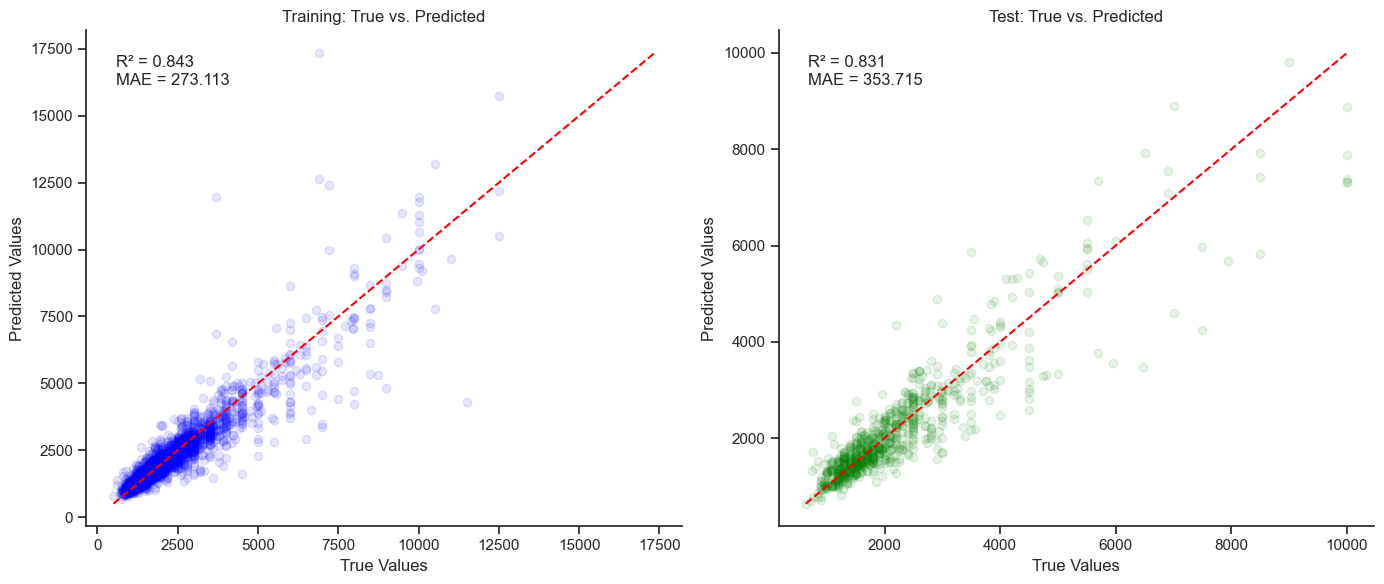

In [73]:
plot_true_vs_pred(trimmed_linear_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

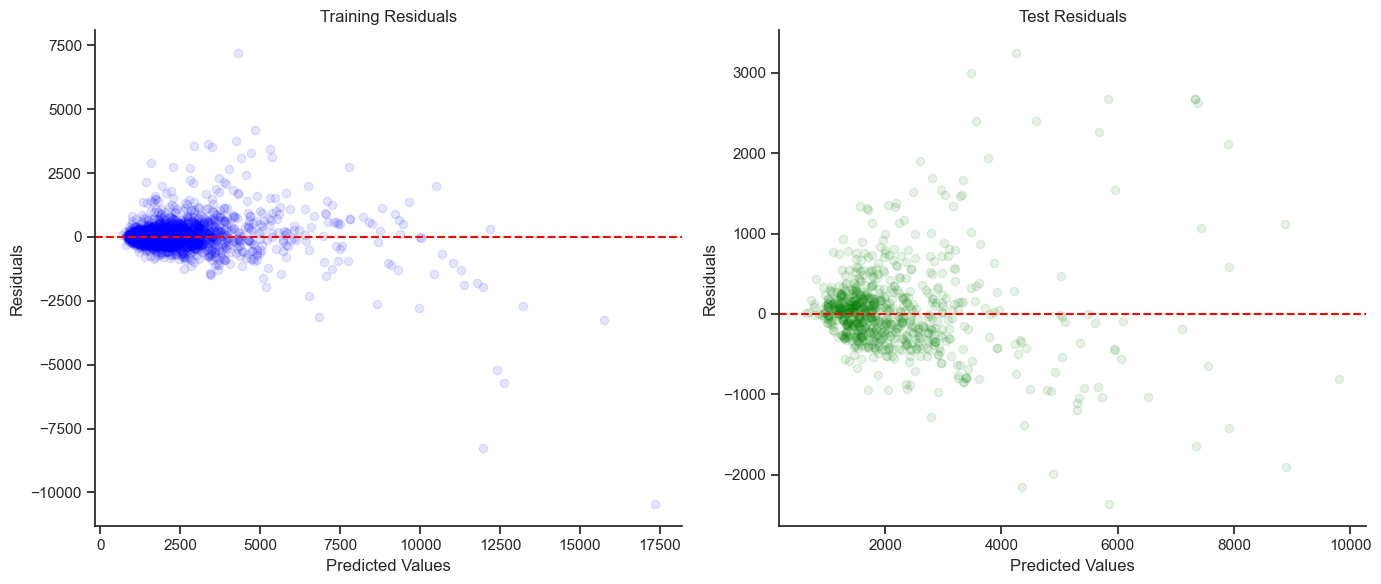

In [74]:
plot_residuals(trimmed_linear_model, X_train, y_train, X_test, y_test, target_transformer=target_transformer_pipeline,)

In [75]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the Gradient Boosting model
gbr_model = GradientBoostingRegressor(random_state=42)

# Parameter grid to search
param_grid = {
    'n_estimators': [10, 20, 30],   # Number of trees
    'max_depth': [3, 4, 5, 6],            # Maximum depth of each tree
    'learning_rate': [0.1, 0.05, 0.01],   # Learning rate
}

# Grid search with cross-validation
grid_search = GridSearchCV(gbr_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train.squeeze())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [10, 20, 30]},
             scoring='neg_mean_squared_error')

In [76]:
best_gbr_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
best_gbr_model.fit(X_train, y_train.squeeze())

GradientBoostingRegressor(max_depth=6, n_estimators=30, random_state=42)

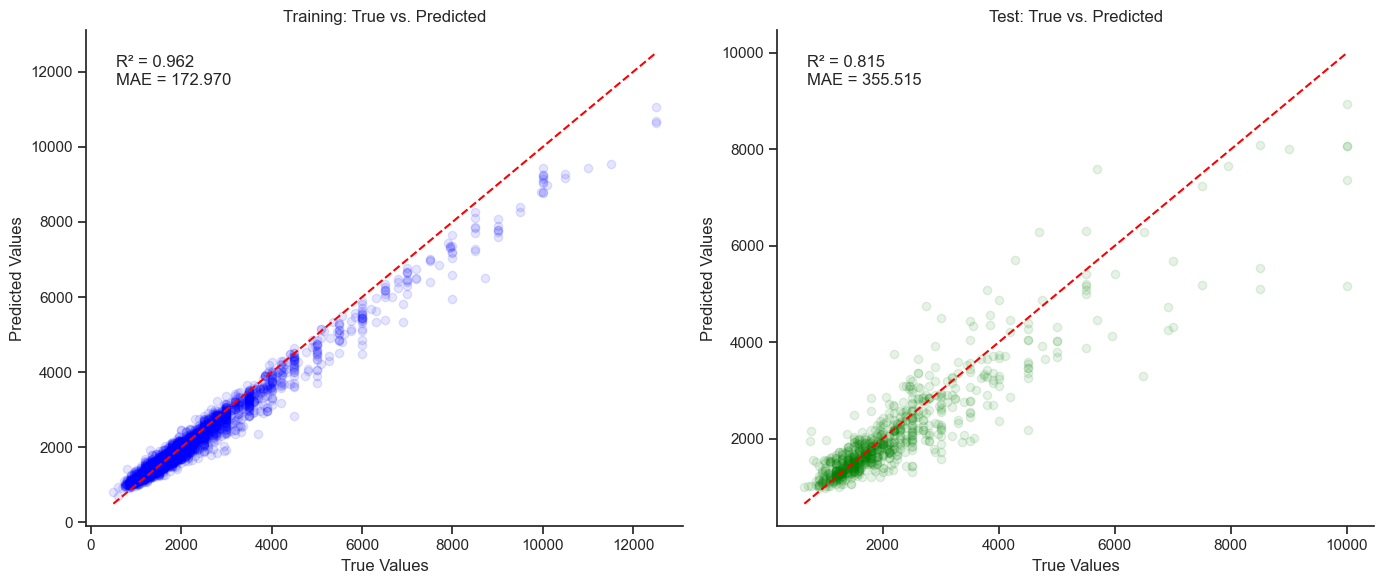

In [77]:
plot_true_vs_pred(best_gbr_model, X_train, y_train.squeeze(), X_test, y_test.squeeze(), target_transformer=target_transformer_pipeline,)

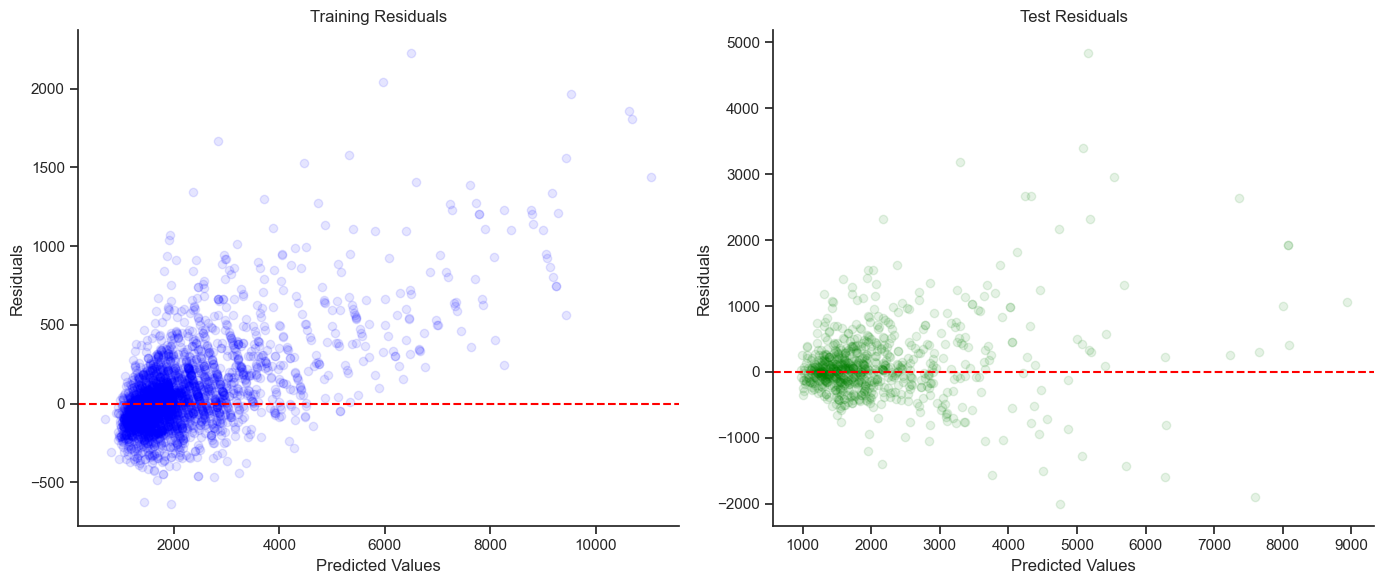

In [78]:
plot_residuals(best_gbr_model, X_train, y_train.squeeze(), X_test, y_test.squeeze(), target_transformer=target_transformer_pipeline,)